# Titanic competition
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).


# Artificial neural networks

Artificial neural networks (ANNs) are comprised of a node layers, containing an input layer, one or more hidden layers, and an output layer. Each node, or artificial neuron, connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network.

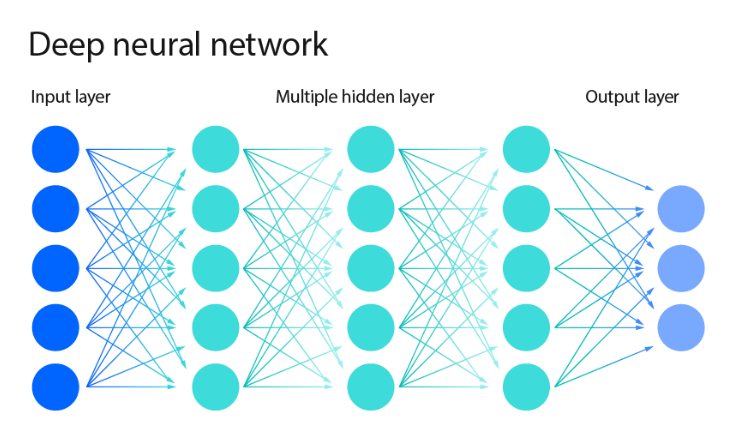

Source: https://www.ibm.com/topics/neural-networks


# Keras and TensorFlow

In this notebook I used Keras and TensorFlow to construct an Artificial Neural Network (ANN). This consists of the knowledge learned in the 'Intro to Deep Learning' course available on Kaggle.

# Data preprocessing

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')
train = pd.read_csv('/kaggle/input/titanic/train.csv')

In [3]:
train['Embarked'] = pd.Categorical(train['Embarked'])
train['Embarked'] = train['Embarked'].cat.codes

train['Age'] = train['Age'].apply(lambda x: 27.0 if np.isnan(x)==True else x)
train['Age_cat'] = train['Age'].apply(lambda x: '0-6' if x<=6 else ('6-12' if x<=12 else ('12-18') if x<=18 else ('18-24') if x<=24 else ('24-30' if x<=30 else ('30-40' if x<=40 else ('40-55' if x<=55 else '55+')))))
train['Age_cat'] = pd.Categorical(train['Age_cat'])
train['Age_cat'] = train['Age_cat'].cat.codes

train['Family'] = train['SibSp'] + train['Parch']
train['Family'] = train['Family'].apply(lambda x: 1 if x>0 else 0)

train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.')
train['Title'] = train['Title'].apply(lambda x: 'Miss' if (x == 'Ms')|(x=='Miss')|(x=='Mlle') else ('Mrs' if (x == 'Mrs')|(x=='Mme') else ('Mr' if x=='Mr' else ('Master' if x=='Master' else 'Other'))))
train['Title'] = pd.Categorical(train['Title'])
train['Title'] = train['Title'].cat.codes

train['Sex'] = train['Sex'].apply(lambda x: 0 if x=='male' else 1)

In [4]:
X = train[['Sex', 'Pclass', 'Fare', 'Embarked', 'Title', 'Family']]
y = train['Survived']

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.8)

input_shape = [X_train.shape[1]]

# Model

In [6]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(4, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid'),
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 6)                 24        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_2 (Bat  (None, 32)                1

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy',
    metrics=['binary_accuracy'],)

# Evaluation

Epoch 1/1000
2/2 [==============================] - 4s 451ms/step - loss: 0.9165 - binary_accuracy: 0.4817 - val_loss: 0.7138 - val_binary_accuracy: 0.3687
Epoch 2/1000
2/2 [==============================] - 0s 49ms/step - loss: 0.8540 - binary_accuracy: 0.5084 - val_loss: 0.7067 - val_binary_accuracy: 0.3687
Epoch 3/1000
2/2 [==============================] - 0s 47ms/step - loss: 0.7980 - binary_accuracy: 0.5520 - val_loss: 0.7040 - val_binary_accuracy: 0.3743
Epoch 4/1000
2/2 [==============================] - 0s 44ms/step - loss: 0.7459 - binary_accuracy: 0.6067 - val_loss: 0.7018 - val_binary_accuracy: 0.3687
Epoch 5/1000
2/2 [==============================] - 0s 44ms/step - loss: 0.7046 - binary_accuracy: 0.6306 - val_loss: 0.7002 - val_binary_accuracy: 0.4469
Epoch 6/1000
2/2 [==============================] - 0s 48ms/step - loss: 0.6866 - binary_accuracy: 0.6376 - val_loss: 0.6988 - val_binary_accuracy: 0.4469
Epoch 7/1000
2/2 [==============================] - 0s 48ms/step - lo

<Axes: title={'center': 'Accuracy'}>

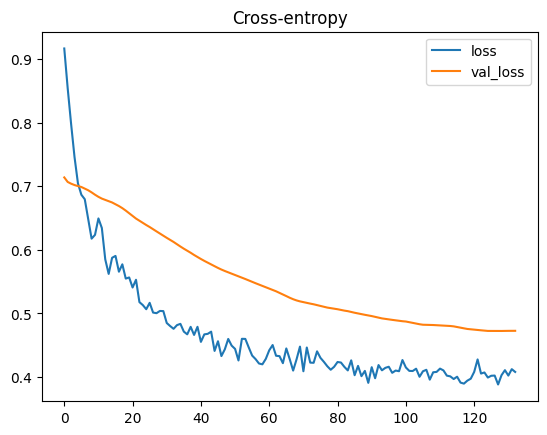

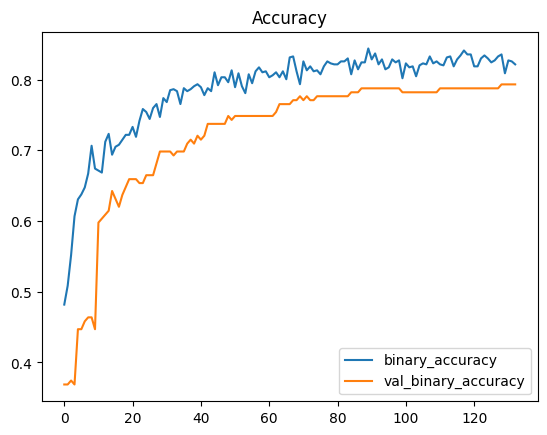

In [9]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=8,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=1000,
    batch_size=512,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

# Predictions and submission

In [10]:
test['Age'].median()
test['Sex'] = test['Sex'].apply(lambda x: 0 if x=='male' else 1)
test['Age'] = test['Age'].apply(lambda x: 27.0 if np.isnan(x)==True else x)
test['Age_cat'] = test['Age'].apply(lambda x: '0-6' if x<=6 else ('6-12' if x<=12 else ('12-18') if x<=18 else ('18-24') if x<=24 else ('24-30' if x<=30 else ('30-40' if x<=40 else ('40-55' if x<=55 else '55+')))))
test['Age_cat'] = pd.Categorical(test['Age_cat'])
test['Age_cat'] = test['Age_cat'].cat.codes
test['Embarked'] = pd.Categorical(test['Embarked'])
test['Embarked'] = test['Embarked'].cat.codes
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.')
test['Title'] = test['Title'].apply(lambda x: 'Miss' if (x == 'Ms')|(x=='Miss')|(x=='Mlle') else ('Mrs' if (x == 'Mrs')|(x=='Mme') else ('Mr' if x=='Mr' else ('Master' if x=='Master' else 'Other'))))
test['Title'] = pd.Categorical(test['Title'])
test['Title'] = test['Title'].cat.codes
test['Family'] = test['SibSp'] + test['Parch']
test['Family'] = test['Family'].apply(lambda x: 1 if x>0 else 0)
test_X = test[['Sex', 'Pclass', 'Fare', 'Embarked', 'Title', 'Family']]

In [11]:
pd.DataFrame(test_X).fillna(0, inplace=True)
median = test_X.median()
test_X['Fare'] = test_X['Fare'].fillna(median)

/tmp/ipykernel_19/1770064310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X['Fare'] = test_X['Fare'].fillna(median)


In [12]:
df = pd.DataFrame()
test_X = StandardScaler().fit_transform(test_X)
df['PassengerId'] = test['PassengerId']
df['Survived'] = model.predict(test_X).round().astype(int)

14/14 [==============================] - 0s 2ms/step


In [13]:
df.to_csv('submission.csv',index=False)